# SynFerm Exploratory Data Analysis
#### Targets:
- See some of the basic trends in the data (which BBs react well? which not at all?)
- perform basic statistics (How many successful reactions?)

#### Sections:
1. [Load and filter data](#1)
2. [Investigate "invalid" reactions](#2)
3. [General Statistics](#3)
4. [Building Block Statistics](#4)
5. [Trends within builing block classes](#5)
6. [Trends within builing block classes, corrected for monomers performance](#6)

In [6]:
import sys
import os

sys.path.insert(0, os.path.abspath('../..'))

from src.definitions import DB_PATH
from src.util.db_utils import MyDatabaseConnection

### Load and filter data <a id='section_id'></a>

In [7]:
from copy import deepcopy
import sqlite3

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100  # this makes the figures bigger in jupyter nb

In [8]:
db = MyDatabaseConnection()  # we will use this for various simple queries

In [9]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False ,parse_dates={'synthesis_date_unixepoch': {'utc': False, 'unit': 's'}})
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 58664


### Select experiments for analysis

In [10]:
# show all available experiments with reaction counts
df_full["exp_nr"].value_counts().sort_index()

1        1920
2        1920
3        1920
4        1920
5        1920
6        1920
7        1920
8        1920
9        1920
10       1920
11       1920
12       1920
13       1920
14       1920
15       1920
16       1920
17       1920
18       1920
19       1920
20       1920
21       1920
22       1920
23       1920
24       1920
25       1920
26       1920
27       1920
28       1920
29       1920
99000     384
99001     648
99002     592
99003      16
99004     384
99005     960
Name: exp_nr, dtype: int64

In [11]:
# select experiment numbers for further analysis
start_exp_nr = 4  # kick out invalid experiments (SOP changed after exp3)
end_exp_nr = 27  # (inclusive)

df_full = df_full.loc[df_full['exp_nr'].between(start_exp_nr, end_exp_nr)]  
print(f'Number of reactions since SOP change and without test reactions: {len(df_full)}')

Number of reactions since SOP change and without test reactions: 46080


### Investigate "invalid" reactions <a id=2></a>

In [12]:
# how many reactions might be invalid?
df_full.loc[:,'valid'].value_counts().head(10)

heating failure                                                                  1920
too many peaks for product A (2)                                                  489
ERROR: too many peaks for IS (2); WARNING: IS response differs >50% from mean     426
ERROR: too many peaks for IS (2)                                                  321
too many peaks for product A (3)                                                  207
ERROR: too many peaks for product A (5)                                           206
ERROR: I/M transfer error                                                         173
Name: valid, dtype: int64

In [13]:
# let's see these invalid reactions
df_full.loc[df_full['valid'] == 'too many peaks for product A (4)']

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_A_smiles,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid
id,,,,,,,,,,,,,,,,,,,,,
11548,4,2,A13,JG247,2021-07-15,I15,M63,T28,4-Pym001,Spiro005,...,COc1cc(C(=O)NCC2(c3nnc(-c4ccc(C(F)(F)F)cc4)s3)...,COc1cc(C(=O)NCC2(C3(C(=O)O)NN=C(c4ccc(C(F)(F)F...,COc1cc(C2=[N+]3N=C(c4ccc(C(F)(F)F)cc4)SC3(C(=O...,COc1cc(-c2nnc(-c3ccc(C(F)(F)F)cc3)s2)ncn1,FC(F)(F)c1ccc(-c2nnc(-c3ccc(C(F)(F)F)cc3)s2)cc1,COc1cc(C(=O)NCC2(C(=O)C(=O)O)CCOCC2)ncn1,COc1cc(C(=O)NCC2(C(=O)O)CCOCC2)ncn1,None,45046,too many peaks for product A (4)
11654,4,2,F19,JG247,2021-07-15,I18,M63,T3,4-Pyrazole002,Spiro005,...,Cc1ccc2nc(C3(CNC(=O)n4nccc4C(=O)OC(C)(C)C)CCOC...,Cc1ccc2c(c1)SC(C(=O)O)(C1(CNC(=O)n3nccc3C(=O)O...,Cc1ccc2c(c1)SC1(C(=O)[O-])[N+]2=C(n2nccc2C(=O)...,Cc1ccc2nc(-n3nccc3C(=O)OC(C)(C)C)sc2c1,Cc1ccc(N)c(SSc2cc(C)ccc2N)c1,CC(C)(C)OC(=O)c1ccnn1C(=O)NCC1(C(=O)C(=O)O)CCOCC1,CC(C)(C)OC(=O)c1ccnn1C(=O)NCC1(C(=O)O)CCOCC1,O,54123,too many peaks for product A (4)
12822,4,5,A7,JG250,2021-07-15,I15,M4,T20,4-Pym001,Fused011,...,COc1cc(C(=O)N[C@H]2COc3ccccc3[C@@H]2c2nnc(-c3c...,COc1cc(C(=O)N[C@H]2COc3ccccc3[C@@H]2C2(C(=O)O)...,COc1cc(C2=[N+]3N=C(c4cccs4)SC3(C(=O)[O-])[C@H]...,COc1cc(-c2nnc(-c3cccs3)s2)ncn1,c1csc(-c2nnc(-c3cccs3)s2)c1,COc1cc(C(=O)N[C@H]2COc3ccccc3[C@@H]2C(=O)C(=O)...,COc1cc(C(=O)N[C@H]2COc3ccccc3[C@@H]2C(=O)O)ncn1,C1=C(c2nnc(-c3cccs3)s2)c2ccccc2OC1,42619,too many peaks for product A (4)
12823,4,5,A8,JG250,2021-07-15,I15,M4,T7,4-Pym001,Fused011,...,COc1cc(C(=O)N[C@H]2COc3ccccc3[C@@H]2c2nc3cc(C)...,COc1cc(C(=O)N[C@H]2COc3ccccc3[C@@H]2C2(C(=O)O)...,COc1cc(C2=[N+]3c4cc(C)ccc4SC3(C(=O)[O-])[C@H]3...,COc1cc(-c2nc3cc(C)ccc3s2)ncn1,Cc1ccc(SSc2ccc(C)cc2N)c(N)c1,COc1cc(C(=O)N[C@H]2COc3ccccc3[C@@H]2C(=O)C(=O)...,COc1cc(C(=O)N[C@H]2COc3ccccc3[C@@H]2C(=O)O)ncn1,Cc1ccc2sc(C3=CCOc4ccccc43)nc2c1,42606,too many peaks for product A (4)
12838,4,5,B3,JG250,2021-07-15,I4,M4,T28,2-Pyr006,Fused011,...,O=C(N[C@H]1COc2ccccc2[C@@H]1c1nnc(-c2ccc(C(F)(...,O=C(N[C@H]1COc2ccccc2[C@@H]1C1(C(=O)O)NN=C(c2c...,O=C([O-])C12SC(c3ccc(C(F)(F)F)cc3)=N[N+]1=C(c1...,FC(F)(F)c1ccc(-c2nnc(-c3ccc(Br)cn3)s2)cc1,FC(F)(F)c1ccc(-c2nnc(-c3ccc(C(F)(F)F)cc3)s2)cc1,O=C(O)C(=O)[C@H]1c2ccccc2OC[C@@H]1NC(=O)c1ccc(...,O=C(N[C@H]1COc2ccccc2[C@@H]1C(=O)O)c1ccc(Br)cn1,FC(F)(F)c1ccc(-c2nnc(C3=CCOc4ccccc43)s2)cc1,9253,too many peaks for product A (4)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16960,7,5,P5,JG268,2021-09-16,I33,M4,T30,Al038,Fused011,...,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1c1nnc(-c2cc(Cl...,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C1(C(=O)O)NN=C...,CC(C1=[N+]2N=C(c3cc(Cl)cc(Cl)c3)SC2(C(=O)[O-])...,CC(c1ccccc1)c1nnc(-c2cc(Cl)cc(Cl)c2)s1,Clc1cc(Cl)cc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)c1,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C(=O)C(=O)O)c1...,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C(=O)O)c1ccccc1,Clc1cc(Cl)cc(-c2nnc(C3=CCOc4ccccc43)s2)c1,97241,too many peaks for product A (4)
16967,7,5,P12,JG268,2021-09-16,I33,M4,T22,Al038,Fused011,...,COc1ccc(-c2nnc([C@H]3c4ccccc4OC[C@@H]3NC(=O)C(...,COc1ccc(C2=NNC(C(=O)O)([C@H]3c4ccccc4OC[C@@H]3...,COc1ccc(C2=N[N+]3=C(C(C)c4ccccc4)N[C@H]4COc5cc...,COc1ccc(-c2nnc(C(C)c3ccccc3)s2)cc1,COc1ccc(-c2nnc(-c3ccc(OC)cc3)s2)cc1,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C(=O)C(=O)O)c1...,CC(C(=O)N[C@H]1COc2ccccc2[C@@H]1C(=O)O)c1ccccc1,COc1ccc(-c2nnc(C3=CCOc4ccccc43)s2)cc1,97233,too many peaks for product A (4)
16969,7,5,P14,JG268,2021-09-16,I33,M54,T39,Al038,Mon100,...,CC(C(=O)NC[C@@H](c1cccnc1)c1nnc(-c2cn[nH]c2)s1...,CC(C(=O)NC[C@@H](c1cccnc1)C1(C(=O)O)NN=C(c2cn[...,CC(C1=[N+]2N=C(c3cn[nH]c3)SC2(C(=O)[O-])[C@H](...,CC(c1ccccc1)c1nnc(-c2cn[nH]c2)s1,c1n[nH]cc1-c1nnc(-c2cn[nH]c2)s1,CC(C(=O)NC[C@H](C(=O)C(=O)O)c1cccnc1)c1ccccc1,CC(C(=O)NC[C@H](C(=O)O)c1cccnc1)c1ccccc1,C=C(c1cccnc1)c1nnc(-c2cn[nH]c2)s1,99300,too many peaks for product A (4)


Let's have a look at the worst offenders. there might be a structural reason why they give multiple peaks in LCMS

In [14]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (2)', ['initiator']].value_counts()
x

initiator
I65          27
I6           26
I40          25
I14          24
I3           23
I22          22
I7           21
I29          20
I32          20
I4           19
I70          19
I64          19
I50          19
I10          18
I77          17
I5           16
I72          16
I17          15
I15          15
I71          15
I28          14
I47          12
I12          11
I30          11
I25           9
I60           9
I23           8
I33           7
I44           6
I36           5
I18           1
dtype: int64

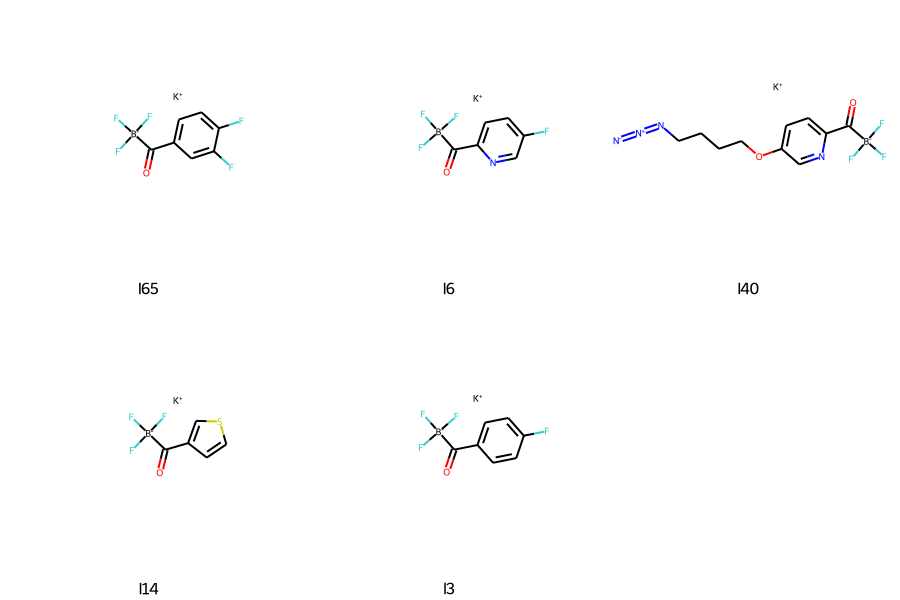

In [15]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [16]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (4)', ['monomer']].value_counts()
x

monomer
M4         22
M54        16
M67         5
M43         4
M63         4
M66         3
M73         3
M29         2
M3          2
M15         1
M32         1
M58         1
M72         1
dtype: int64

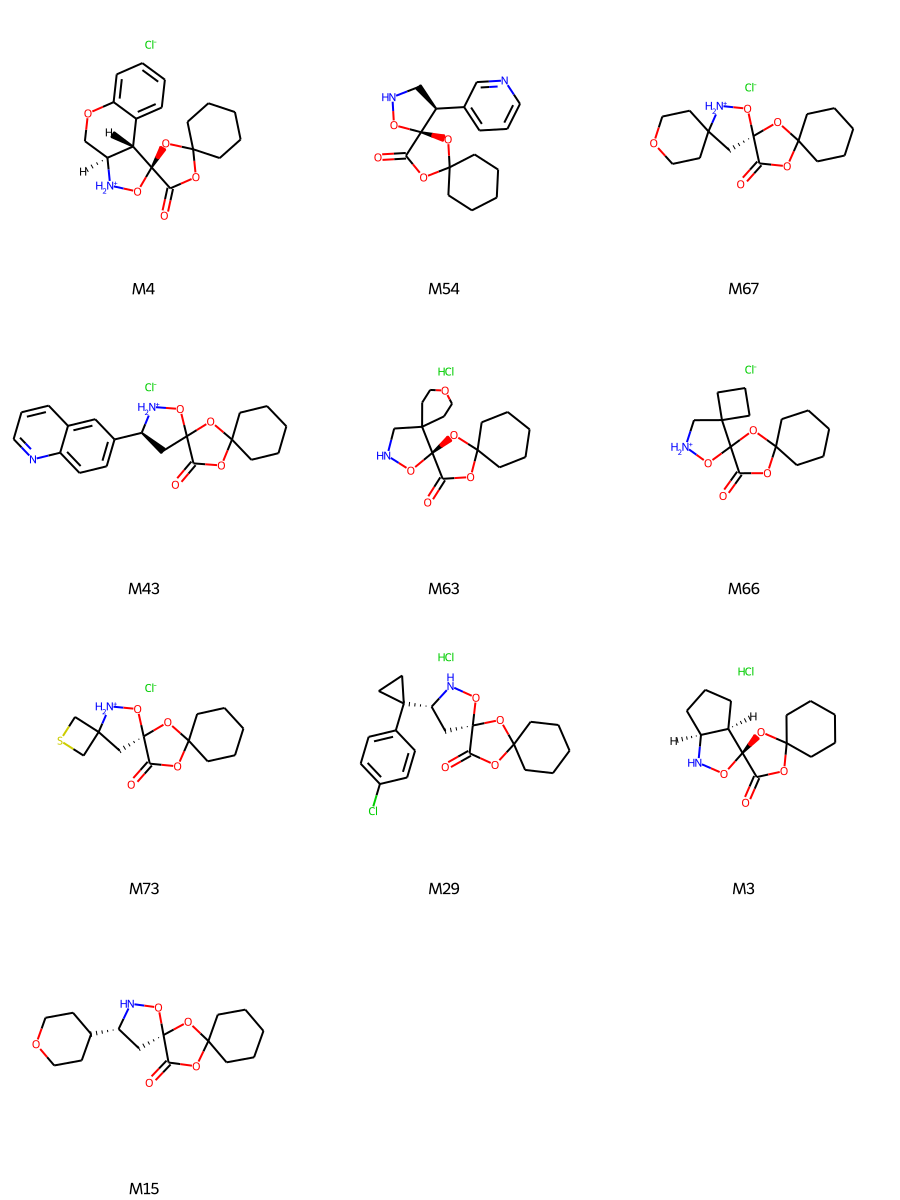

In [17]:
# let's look at these molecules
mols = []
for bb in x.head(10).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

In [18]:
x = df_full.loc[df_full['valid'] == 'too many peaks for product A (4)', ['terminator']].value_counts()
x

terminator
T21           8
T28           8
T1            7
T20           5
T22           5
T30           5
T40           5
T36           4
T3            3
T39           3
T7            3
T13           2
T17           2
T31           2
T34           2
T32           1
dtype: int64

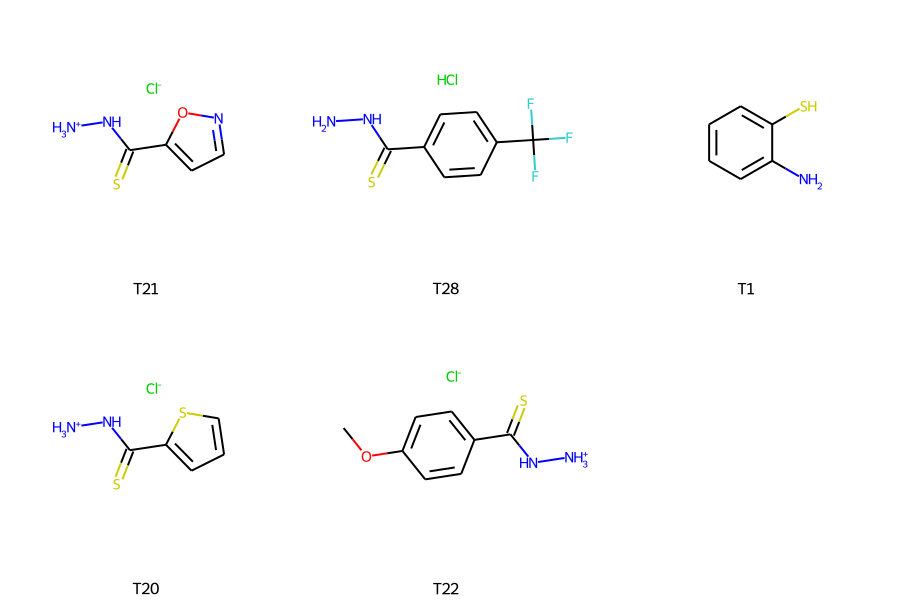

In [19]:
# let's look at these molecules
mols = []
for bb in x.head(5).index.to_list():
    mols.append(db.get_mol(short=bb[0]))
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, subImgSize=(300,300), legends=[bb[0] for bb in x.index.to_list()])

#### Remove invalid reactions
It seems reasonable to assume that up to 4 peaks for A could be from diasteromers + regioisomers so we will accept anything that has 4 or less peaks for A into our cleaned data set

In [20]:
df = df_full.loc[df_full['valid'].isna() 
                 | (df_full['valid'] == 'heating failure') 
                 | (df_full['valid'] == 'too many peaks for product A (2)') 
                 | (df_full['valid'] == 'too many peaks for product A (3)')
                 | (df_full['valid'] == 'too many peaks for product A (4)')
                ] 
print(f'Number of reactions after removing invalid entries: {len(df)}')

Number of reactions after removing invalid entries: 36195


In [21]:
df = df.loc[~df['product_A_lcms_ratio'].isna()]  # remove all entries where product A is NaN (these are the entries not yet measured)
print(f'Number of reactions after removing NaN entries: {len(df)}')

Number of reactions after removing NaN entries: 29155


In [22]:
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_A_smiles,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid
id,,,,,,,,,,,,,,,,,,,,,
9618,5,2,A3,JG253,2021-08-17,I67,M2,T25,Ph023,Fused005,...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(C=C...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C1(C(=O)O...,O=C(OCc1ccccc1)N1C[C@@H]2NC(c3ccc(Cl)cc3)=[N+]...,Clc1ccc(-c2nnc(C=Cc3ccccc3)s2)cc1,C(=Cc1nnc(C=Cc2ccccc2)s1)c1ccccc1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,O=C(OCc1ccccc1)N1CC=C(c2nnc(C=Cc3ccccc3)s2)C1,200310,heating failure
9619,5,2,A4,JG253,2021-08-17,I67,M2,T39,Ph023,Fused005,...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(-c2...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C1(C(=O)O...,O=C(OCc1ccccc1)N1C[C@@H]2NC(c3ccc(Cl)cc3)=[N+]...,Clc1ccc(-c2nnc(-c3cn[nH]c3)s2)cc1,c1n[nH]cc1-c1nnc(-c2cn[nH]c2)s1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,O=C(OCc1ccccc1)N1CC=C(c2nnc(-c3cn[nH]c3)s2)C1,200324,heating failure
9620,5,2,A5,JG253,2021-08-17,I67,M2,T30,Ph023,Fused005,...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1c1nnc(-c2...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C1(C(=O)O...,O=C(OCc1ccccc1)N1C[C@@H]2NC(c3ccc(Cl)cc3)=[N+]...,Clc1ccc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)cc1,Clc1cc(Cl)cc(-c2nnc(-c3cc(Cl)cc(Cl)c3)s2)c1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,O=C(OCc1ccccc1)N1CC=C(c2nnc(-c3cc(Cl)cc(Cl)c3)...,200315,heating failure
9621,5,2,A6,JG253,2021-08-17,I67,M2,T34,Ph023,Fused005,...,CN(C)c1cccc(-c2nnc([C@@H]3CN(C(=O)OCc4ccccc4)C...,CN(C)c1cccc(C2=NNC(C(=O)O)([C@@H]3CN(C(=O)OCc4...,CN(C)c1cccc(C2=N[N+]3=C(c4ccc(Cl)cc4)N[C@H]4CN...,CN(C)c1cccc(-c2nnc(-c3ccc(Cl)cc3)s2)c1,CN(C)c1cccc(-c2nnc(-c3cccc(N(C)C)c3)s2)c1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,CN(C)c1cccc(-c2nnc(C3=CCN(C(=O)OCc4ccccc4)C3)s...,200319,heating failure
9622,5,2,A7,JG253,2021-08-17,I67,M2,T17,Ph023,Fused005,...,CCOc1ccc2nc([C@@H]3CN(C(=O)OCc4ccccc4)C[C@@H]3...,CCOc1ccc2c(c1)SC(C(=O)O)([C@@H]1CN(C(=O)OCc3cc...,CCOc1ccc2c(c1)SC1(C(=O)[O-])[C@@H]3CN(C(=O)OCc...,CCOc1ccc2nc(-c3ccc(Cl)cc3)sc2c1,CCOc1ccc(N)c(SSc2cc(OCC)ccc2N)c1,O=C(O)C(=O)[C@@H]1CN(C(=O)OCc2ccccc2)C[C@@H]1N...,O=C(N[C@H]1CN(C(=O)OCc2ccccc2)C[C@H]1C(=O)O)c1...,CCOc1ccc2nc(C3=CCN(C(=O)OCc4ccccc4)C3)sc2c1,200302,heating failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73997,14,3,P5,JG311,2022-03-29,I57,M60,T14,Ph007,Spiro003,...,COc1ccc(C(=O)NCC2(c3nc4cc(OC)c(OC)cc4s3)CCN(C(...,COc1ccc(C(=O)NCC2(C3(C(=O)O)Nc4cc(OC)c(OC)cc4S...,COc1ccc(C2=[N+]3c4cc(OC)c(OC)cc4SC3(C(=O)[O-])...,COc1ccc(-c2nc3cc(OC)c(OC)cc3s2)c(OC)c1,COc1cc(N)c(SSc2cc(OC)c(OC)cc2N)cc1OC,COc1ccc(C(=O)NCC2(C(=O)C(=O)O)CCN(C(=O)OCC3CCC...,COc1ccc(C(=O)NCC2(C(=O)O)CCN(C(=O)OCC3CCC3)CC2...,O,172378,None
73998,14,3,P6,JG311,2022-03-29,I57,M60,T6,Ph007,Spiro003,...,COc1ccc(C(=O)NCC2(c3nc4ccc(OC(F)(F)F)cc4s3)CCN...,COc1ccc(C(=O)NCC2(C3(C(=O)O)Nc4ccc(OC(F)(F)F)c...,COc1ccc(C2=[N+]3c4ccc(OC(F)(F)F)cc4SC3(C(=O)[O...,COc1ccc(-c2nc3ccc(OC(F)(F)F)cc3s2)c(OC)c1,Nc1ccc(OC(F)(F)F)cc1SSc1cc(OC(F)(F)F)ccc1N,COc1ccc(C(=O)NCC2(C(=O)C(=O)O)CCN(C(=O)OCC3CCC...,COc1ccc(C(=O)NCC2(C(=O)O)CCN(C(=O)OCC3CCC3)CC2...,O,172370,None
73999,14,3,P7,JG311,2022-03-29,I57,M60,T15,Ph007,Spiro003,...,COc1ccc(C(=O)NCC2(c3nc4ccc(Br)cc4s3)CCN(C(=O)O...,COc1ccc(C(=O)NCC2(C3(C(=O)O)Nc4ccc(Br)cc4S3)CC...,COc1ccc(C2=[N+]3c4ccc(Br)cc4SC3(C(=O)[O-])C3(C...,COc1ccc(-c2nc3ccc(Br)cc3s2)c(OC)c1,Nc1ccc(Br)cc1SSc1cc(Br)ccc1N,COc1ccc(C(=O)NCC2(C(=O)C(=O)O)CCN(C(=O)OCC3CCC...,COc1ccc(C(=O)NCC2(C(=O)O)CCN(C(=O)OCC3CCC3)CC2...,O,172379,None


In [23]:
# due to bug 2022-08-12, we cannot consider plates 1-3 from earlier experiments until they are reprocessed
df = df.loc[~((df["exp_nr"] < 17) & (df["plate_nr"] < 4))]
len(df)

23091

Now we have a cleaned dataset. Let's try some basic statistics

How many reactions are successful (i.e. normalized lmcs ratio for A > threshold ?)

In [24]:
# first min-max normalize all the lcms columns seperately

df = deepcopy(df)
lcms_df = df[['product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio', 'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio', 'product_G_lcms_ratio', 'product_H_lcms_ratio']]
df[['A_normalized','B_normalized', 'C_normalized', 'D_normalized', 'E_normalized', 'F_normalized', 'G_normalized', 'H_normalized']] = (lcms_df-lcms_df.min())/(lcms_df.max()-lcms_df.min())
df                                      

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,vl_id,valid,A_normalized,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,201048,heating failure,0.228376,0.145169,0.004820,0.000000,0.012145,0.006604,0.059794,0.000278
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,201062,heating failure,0.035917,0.105225,0.004056,0.000000,0.001908,0.009637,0.062440,0.000000
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,201053,heating failure,0.087476,0.098541,0.000710,0.000000,0.000000,0.008287,0.061370,0.000000
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,201057,heating failure,0.200950,0.288984,0.001253,0.000020,0.008349,0.009118,0.072213,0.000205
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,201040,heating failure,0.067068,0.000000,0.000000,0.000000,0.000000,0.007924,0.607977,0.000581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71117,17,3,P5,JG329,2022-05-18,I44,M9,T26,BiPh007,Mon001,...,130816,None,0.169899,0.002033,0.000743,0.001137,0.033824,0.002605,0.001556,0.000742
71118,17,3,P6,JG329,2022-05-18,I44,M9,T29,BiPh007,Mon001,...,130819,None,0.029490,0.055681,0.000000,0.000418,0.001094,0.003924,0.001102,0.000059
71119,17,3,P7,JG329,2022-05-18,I44,M9,T19,BiPh007,Mon001,...,130809,None,0.058677,0.059896,0.001232,0.001602,0.038898,0.002412,0.000809,0.000341


In [25]:
# add information about reactant classes to df
def get_reaction_type_for_series(ser):
    new = []
    for i in ser:
        new.append(db.get_reactant_class(i))
    return pd.Series(data=new)
        
df[['initiator_type', 'monomer_type', 'terminator_type']] = df[['initiator', 'monomer', 'terminator']].apply(get_reaction_type_for_series, axis=1)
df

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
10578,5,4,A3,JG255,2021-08-17,I67,M20,T25,Ph023,Mon017,...,0.145169,0.004820,0.000000,0.012145,0.006604,0.059794,0.000278,KAT_arom,Mon_sub_3,TerTH
10579,5,4,A4,JG255,2021-08-17,I67,M20,T39,Ph023,Mon017,...,0.105225,0.004056,0.000000,0.001908,0.009637,0.062440,0.000000,KAT_arom,Mon_sub_3,TerTH
10580,5,4,A5,JG255,2021-08-17,I67,M20,T30,Ph023,Mon017,...,0.098541,0.000710,0.000000,0.000000,0.008287,0.061370,0.000000,KAT_arom,Mon_sub_3,TerTH
10581,5,4,A6,JG255,2021-08-17,I67,M20,T34,Ph023,Mon017,...,0.288984,0.001253,0.000020,0.008349,0.009118,0.072213,0.000205,KAT_arom,Mon_sub_3,TerTH
10582,5,4,A7,JG255,2021-08-17,I67,M20,T17,Ph023,Mon017,...,0.000000,0.000000,0.000000,0.000000,0.007924,0.607977,0.000581,KAT_arom,Mon_sub_3,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71117,17,3,P5,JG329,2022-05-18,I44,M9,T26,BiPh007,Mon001,...,0.002033,0.000743,0.001137,0.033824,0.002605,0.001556,0.000742,KAT_arom,Mon_sub_3,TerTH
71118,17,3,P6,JG329,2022-05-18,I44,M9,T29,BiPh007,Mon001,...,0.055681,0.000000,0.000418,0.001094,0.003924,0.001102,0.000059,KAT_arom,Mon_sub_3,TerTH
71119,17,3,P7,JG329,2022-05-18,I44,M9,T19,BiPh007,Mon001,...,0.059896,0.001232,0.001602,0.038898,0.002412,0.000809,0.000341,KAT_arom,Mon_sub_3,TerTH


### General Statistics <a id=3></a>

Let's look at how well reactions have worked across the (cleaned) data set

In [26]:
for threshold in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    t_and_f = (df['A_normalized'] >= threshold).value_counts()
    print(f'This ratio of reactions is above the {threshold:.1%} threshold: {t_and_f[True] / (t_and_f[True]+ t_and_f[False]):.1%}')

This ratio of reactions is above the 0.1% threshold: 64.8%
This ratio of reactions is above the 0.5% threshold: 48.8%
This ratio of reactions is above the 1.0% threshold: 40.3%
This ratio of reactions is above the 5.0% threshold: 19.0%
This ratio of reactions is above the 10.0% threshold: 9.6%
This ratio of reactions is above the 20.0% threshold: 3.2%


For a graphical assessment, we plot the histogramms for all normalized product yields

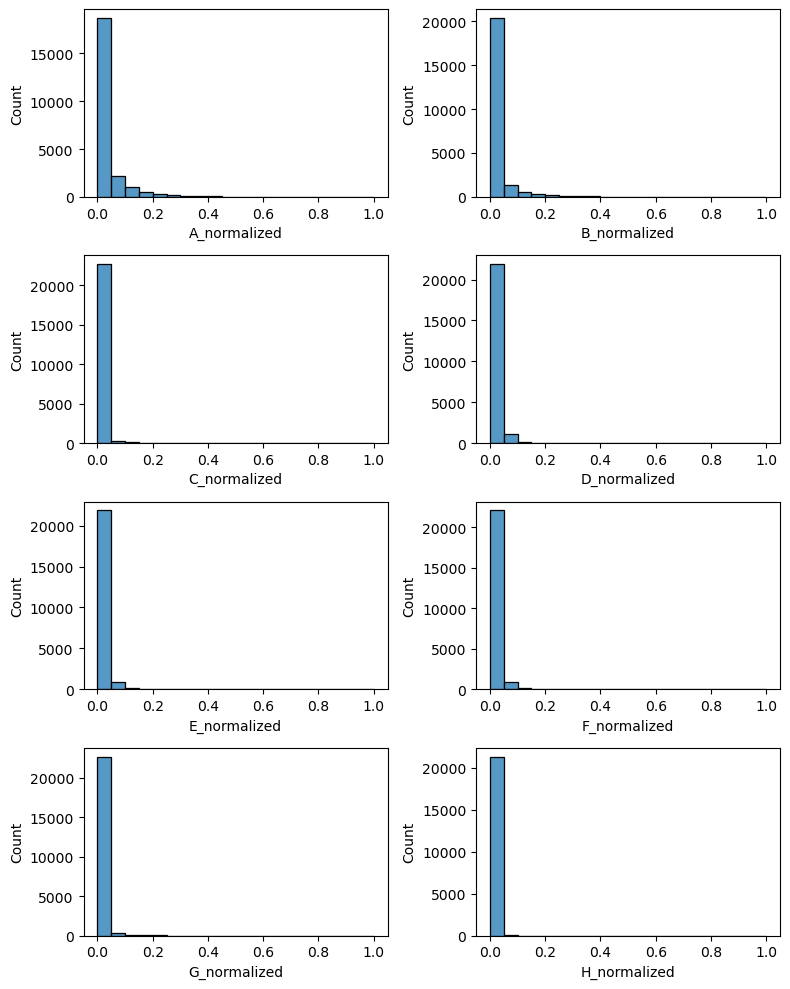

In [27]:
nbins = 20
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8,10))
sns.histplot(df['A_normalized'], bins=nbins, ax=axs[0][0])
sns.histplot(df['B_normalized'], bins=nbins, ax=axs[0][1])
sns.histplot(df['C_normalized'], bins=nbins, ax=axs[1][0])
sns.histplot(df['D_normalized'], bins=nbins, ax=axs[1][1])
sns.histplot(df['E_normalized'], bins=nbins, ax=axs[2][0])
sns.histplot(df['F_normalized'], bins=nbins, ax=axs[2][1])
sns.histplot(df['G_normalized'], bins=nbins, ax=axs[3][0])
sns.histplot(df['H_normalized'], bins=nbins, ax=axs[3][1])
plt.tight_layout()
plt.show()

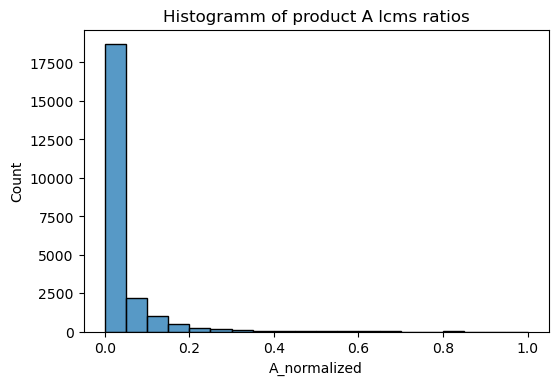

In [28]:
plt.figure()
sns.histplot(df['A_normalized'], bins=20)
plt.title('Histogramm of product A lcms ratios')
plt.show()

<Figure size 600x400 with 0 Axes>

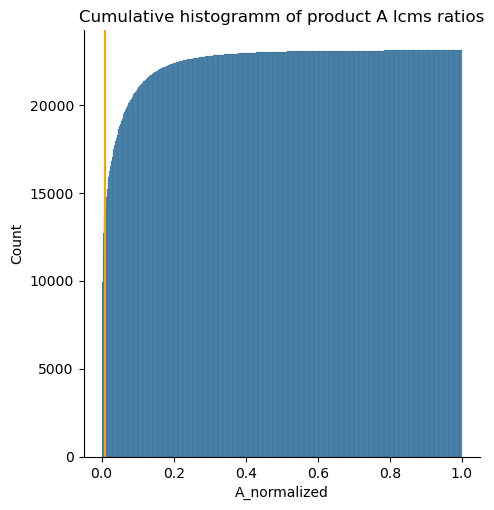

In [29]:
# let's see the same as a cumulative histogramm
plt.figure()
sns.displot(df['A_normalized'], cumulative=True)
plt.title('Cumulative histogramm of product A lcms ratios')
plt.axvline(x=0.01, color='orange')
plt.show()

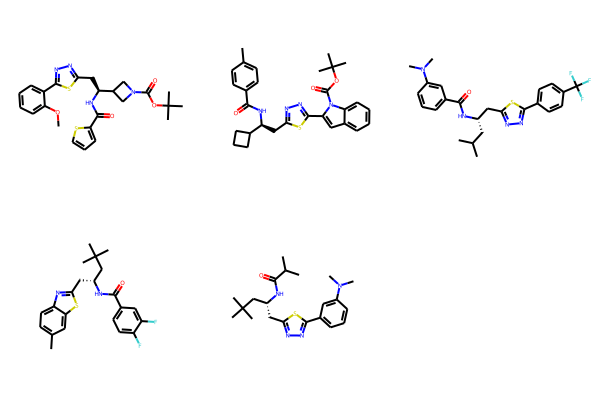

In [30]:
# What products have the highest "yields"?
from rdkit.Chem.AllChem import Compute2DCoords, EmbedMolecule, GenerateDepictionMatching3DStructure, Draw
products = []
for vl_id in df.sort_values('A_normalized', ascending=False).head(5)['vl_id']:
    products.append(db.get_vl_member(vl_id))
[Compute2DCoords(p) for p in products]
Draw.MolsToGridImage(products)

In [31]:
# let's check the highest "yielding" reaction
df.sort_values('A_normalized', ascending=False).head(1)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
61787,18,1,N15,JG333,2022-05-31,I9,M5,T31,2-Thio001,Mon096,...,0.253225,0.000999,0.006475,0.035807,0.003142,0.002776,0.000178,KAT_hetarom,Mon_sub_3,TerTH


### Building Block statistics <a id=4></a>

Let's look into details: __For each initator, how many reactions have worked above the threshold?__

In [32]:
THRESHOLD = 0.01

In [33]:
def calc_success_rate(df, column, threshold, sort_results=True):
    """
    Take a dataframe df, where for one column of interest, for each unique identifier in that column, the frequency
    of successful reactions (as indicated by the threshold) is calculated.
    :param df: pandas.DataFrame
    :param column: Column by which to group, e.g. monomer or monomer_type
    :param threshold: float, threshold for success
    :return: pandas.DataFrame
    """
    success_rates = []
    for i in df[column].unique():
        df_i = df.loc[df[column] == i]
        n_all = len(df_i)
        n_success = len(df_i.loc[df['A_normalized'] >= threshold])
        success_rates.append([i, n_success, n_all, n_success/n_all])
    if sort_results is True:
        success_rates = sorted(success_rates, key=lambda x: int(x[0][1:]))
    return pd.DataFrame(success_rates, columns=[column, 'n_success', 'n_all', 'success_rate'])

In [34]:
# we calculate success rates for all initiators
success_rates_by_initiator = calc_success_rate(df, 'initiator', THRESHOLD)
for _, i in success_rates_by_initiator.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for I2: 56.5% (108/191)
Success rate for I3: 51.0% (317/621)
Success rate for I4: 36.7% (104/283)
Success rate for I5: 53.2% (151/284)
Success rate for I6: 31.2% (176/565)
Success rate for I7: 60.7% (368/606)
Success rate for I8: 49.1% (132/269)
Success rate for I9: 59.6% (124/208)
Success rate for I10: 46.9% (302/644)
Success rate for I11: 38.5% (89/231)
Success rate for I12: 42.2% (117/277)
Success rate for I13: 55.2% (122/221)
Success rate for I14: 43.1% (116/269)
Success rate for I15: 45.3% (110/243)
Success rate for I17: 40.3% (252/626)
Success rate for I18: 0.9% (3/337)
Success rate for I19: 24.8% (70/282)
Success rate for I20: 26.6% (73/274)
Success rate for I21: 32.7% (36/110)
Success rate for I22: 32.3% (180/557)
Success rate for I23: 33.3% (87/261)
Success rate for I24: 43.9% (58/132)
Success rate for I25: 52.8% (366/693)
Success rate for I26: 38.1% (119/312)
Success rate for I27: 60.9% (173/284)
Success rate for I28: 20.2% (64/317)
Success rate for I29: 42.7% (1

In [35]:
# let's do the same for monomers
success_rates_by_monomer = calc_success_rate(df, 'monomer', THRESHOLD)
for _, i in success_rates_by_monomer.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for M1: 23.9% (76/318)
Success rate for M2: 32.5% (96/295)
Success rate for M3: 3.8% (14/370)
Success rate for M4: 31.9% (104/326)
Success rate for M5: 76.1% (251/330)
Success rate for M6: 35.6% (114/320)
Success rate for M7: 19.7% (63/320)
Success rate for M8: 19.1% (61/320)
Success rate for M9: 41.9% (134/320)
Success rate for M10: 63.9% (484/758)
Success rate for M11: 46.9% (226/482)
Success rate for M12: 0.0% (0/175)
Success rate for M13: 57.2% (183/320)
Success rate for M16: 61.9% (227/367)
Success rate for M17: 68.5% (350/511)
Success rate for M18: 62.9% (253/402)
Success rate for M19: 15.4% (14/91)
Success rate for M20: 73.7% (484/657)
Success rate for M21: 61.4% (366/596)
Success rate for M23: 81.6% (261/320)
Success rate for M24: 82.1% (192/234)
Success rate for M27: 0.0% (0/602)
Success rate for M28: 57.2% (258/451)
Success rate for M29: 41.0% (181/441)
Success rate for M30: 66.2% (212/320)
Success rate for M31: 22.3% (55/247)
Success rate for M32: 66.7% (232/348

In [36]:
# and the same for terminators
success_rates_by_terminator = calc_success_rate(df, 'terminator', THRESHOLD)
for _, i in success_rates_by_terminator.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for T1: 40.2% (249/620)
Success rate for T2: 30.1% (255/846)
Success rate for T3: 55.2% (366/663)
Success rate for T4: 60.5% (297/491)
Success rate for T5: 3.2% (28/888)
Success rate for T6: 7.5% (37/492)
Success rate for T7: 48.8% (331/678)
Success rate for T8: 7.9% (51/647)
Success rate for T9: 0.0% (0/172)
Success rate for T10: 8.9% (42/474)
Success rate for T11: 4.3% (37/863)
Success rate for T12: 31.5% (263/835)
Success rate for T13: 45.7% (320/700)
Success rate for T14: 62.1% (315/507)
Success rate for T15: 13.6% (66/487)
Success rate for T16: 7.8% (20/256)
Success rate for T17: 40.3% (250/621)
Success rate for T18: 1.2% (8/659)
Success rate for T19: 60.3% (411/682)
Success rate for T20: 60.9% (285/468)
Success rate for T21: 25.9% (121/467)
Success rate for T22: 57.6% (300/521)
Success rate for T23: 51.7% (351/679)
Success rate for T24: 68.0% (289/425)
Success rate for T25: 29.7% (176/592)
Success rate for T26: 61.1% (427/699)
Success rate for T27: 59.9% (318/531)
Su

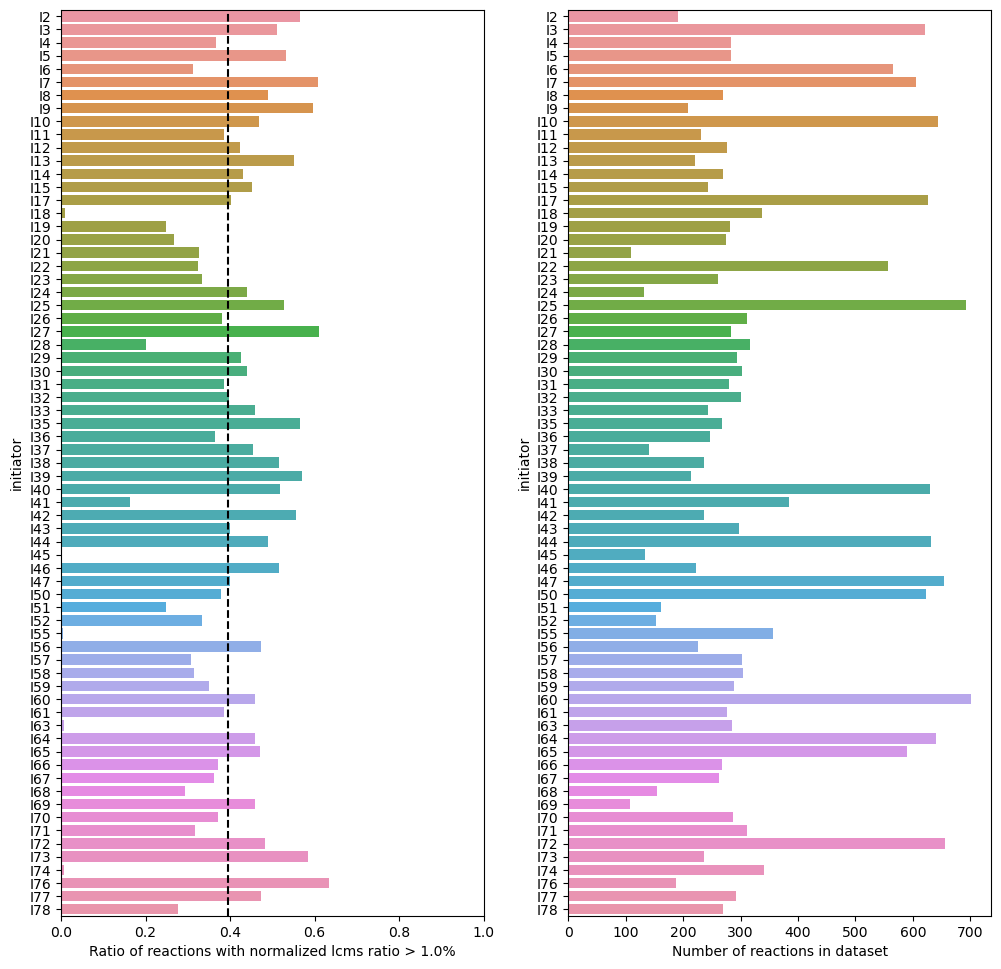

In [37]:
# show how many reactions are successful for each initiator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

axs[0].axvline(success_rates_by_initiator['success_rate'].mean(), ls='--', c='black')  # draw a mean line
sns.barplot(x=success_rates_by_initiator['success_rate'], y=success_rates_by_initiator['initiator'], ax=axs[0])
sns.barplot(x=success_rates_by_initiator['n_all'], y=success_rates_by_initiator['initiator'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

In [38]:
db.get_smiles("T18")

'Cc1cccc(S)c1N'

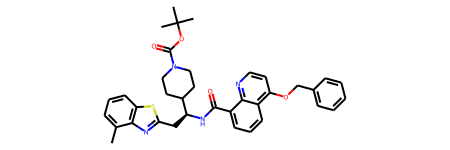

In [39]:
db.get_vl_member(65085)

In [40]:
df.columns

Index(['exp_nr', 'plate_nr', 'well', 'lab_journal_number',
       'synthesis_date_unixepoch', 'initiator', 'monomer', 'terminator',
       'initiator_long', 'monomer_long', 'terminator_long', 'long_name',
       'product_A_lcms_ratio', 'product_B_lcms_ratio', 'product_C_lcms_ratio',
       'product_D_lcms_ratio', 'product_E_lcms_ratio', 'product_F_lcms_ratio',
       'product_G_lcms_ratio', 'product_H_lcms_ratio', 'comment',
       'product_A_smiles', 'product_B_smiles', 'product_C_smiles',
       'product_D_smiles', 'product_E_smiles', 'product_F_smiles',
       'product_G_smiles', 'product_H_smiles', 'vl_id', 'valid',
       'A_normalized', 'B_normalized', 'C_normalized', 'D_normalized',
       'E_normalized', 'F_normalized', 'G_normalized', 'H_normalized',
       'initiator_type', 'monomer_type', 'terminator_type'],
      dtype='object')

In [41]:
(df.loc[df["terminator"] == "T9"]
   # .loc[df["well"] == "B21", :]
)

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,B_normalized,C_normalized,D_normalized,E_normalized,F_normalized,G_normalized,H_normalized,initiator_type,monomer_type,terminator_type
id,,,,,,,,,,,,,,,,,,,,,
32083,13,5,A11,JG307,2022-03-15,I39,M4,T9,BiPh002,Fused011,...,0.0,0.0,0.000114,0.014194,0.005684,0.003364,0.0,KAT_arom,Mon_fused,TerABT
32093,13,5,A21,JG307,2022-03-15,I39,M54,T9,BiPh002,Mon100,...,0.0,0.0,0.002287,0.027547,0.028773,0.015421,0.0,KAT_arom,Mon_sub_2,TerABT
32103,13,5,B11,JG307,2022-03-15,I2,M4,T9,2-Pyr003,Fused011,...,0.0,0.0,0.000000,0.032207,0.017811,0.001489,0.0,KAT_hetarom,Mon_fused,TerABT
32113,13,5,B21,JG307,2022-03-15,I2,M54,T9,2-Pyr003,Mon100,...,0.0,0.0,0.000232,0.031893,0.020318,0.007293,0.0,KAT_hetarom,Mon_sub_2,TerABT
32153,13,5,D21,JG307,2022-03-15,I13,M54,T9,3-Pyr004,Mon100,...,0.0,0.0,0.000000,0.034711,0.001376,0.000000,0.0,KAT_hetarom,Mon_sub_2,TerABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38403,16,6,M11,JG326,2022-05-03,I73,M35,T9,Ph030,Mon077,...,0.0,0.0,0.001616,0.023496,0.009212,0.001109,0.0,KAT_arom,Mon_sub_3,TerABT
38413,16,6,M21,JG326,2022-05-03,I73,M45,T9,Ph030,Mon091,...,0.0,0.0,0.000407,0.033359,0.039197,0.002291,0.0,KAT_arom,Mon_sub_3,TerABT
38423,16,6,N11,JG326,2022-05-03,I9,M35,T9,2-Thio001,Mon077,...,0.0,0.0,0.000987,0.034551,0.002079,0.001746,0.0,KAT_hetarom,Mon_sub_3,TerABT


In [42]:
df.loc[38296, "vl_id"]

134900

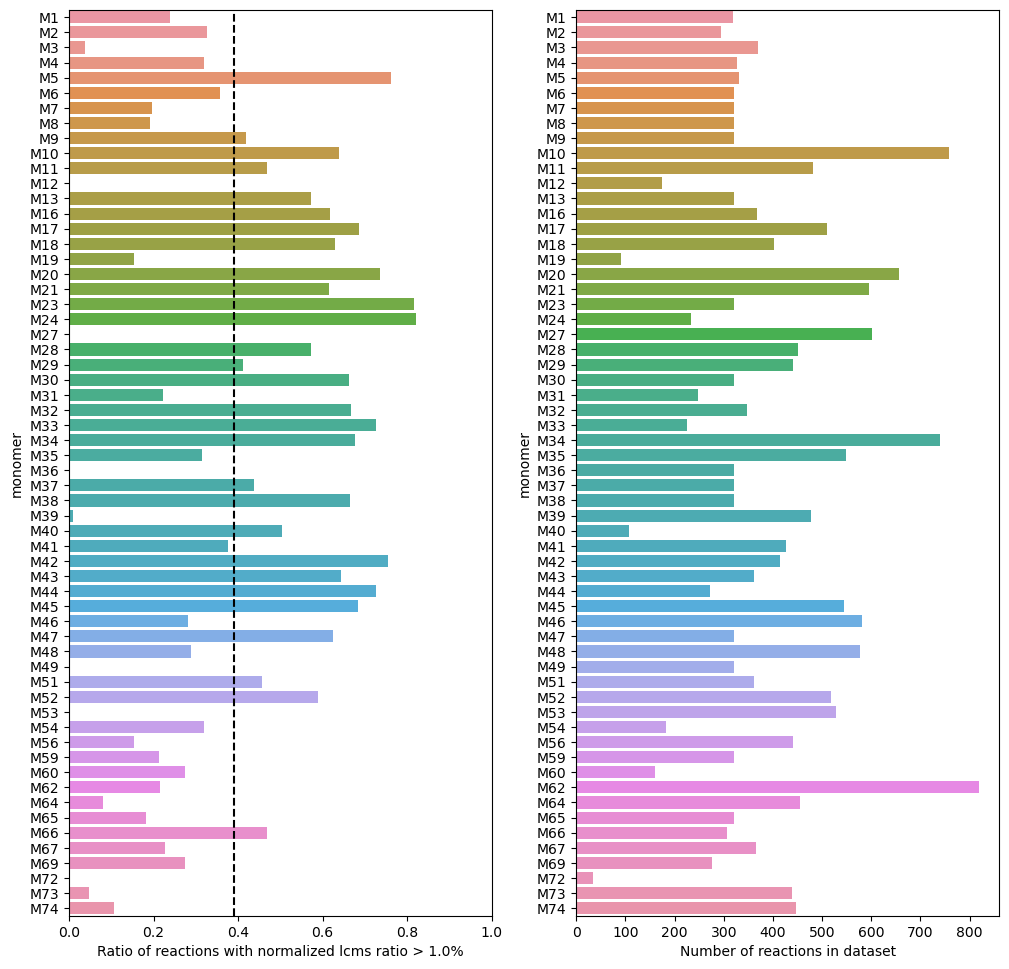

In [43]:
# show how many reactions are successful for each monomer
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

axs[0].axvline(success_rates_by_monomer['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_monomer['success_rate'], y=success_rates_by_monomer['monomer'], ax=axs[0])
sns.barplot(x=success_rates_by_monomer['n_all'], y=success_rates_by_monomer['monomer'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

/Users/julian/miniconda3/envs/library-generation/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


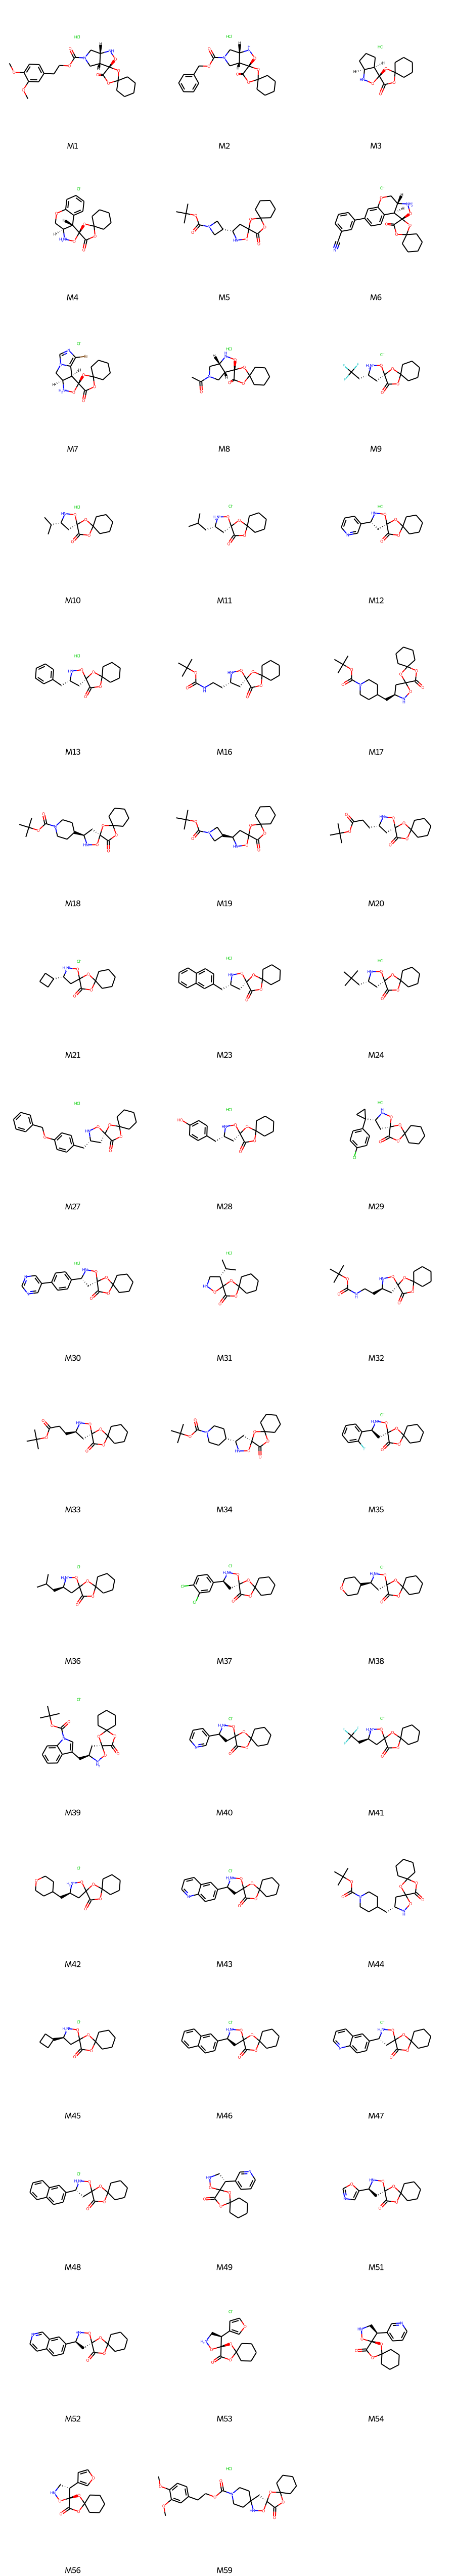

In [44]:
monomer_mols = []
for x in success_rates_by_monomer['monomer']:
    monomer_mols.append(db.get_mol(x))
Draw.MolsToGridImage(monomer_mols, subImgSize=(300, 300), legends=success_rates_by_monomer['monomer'].tolist())

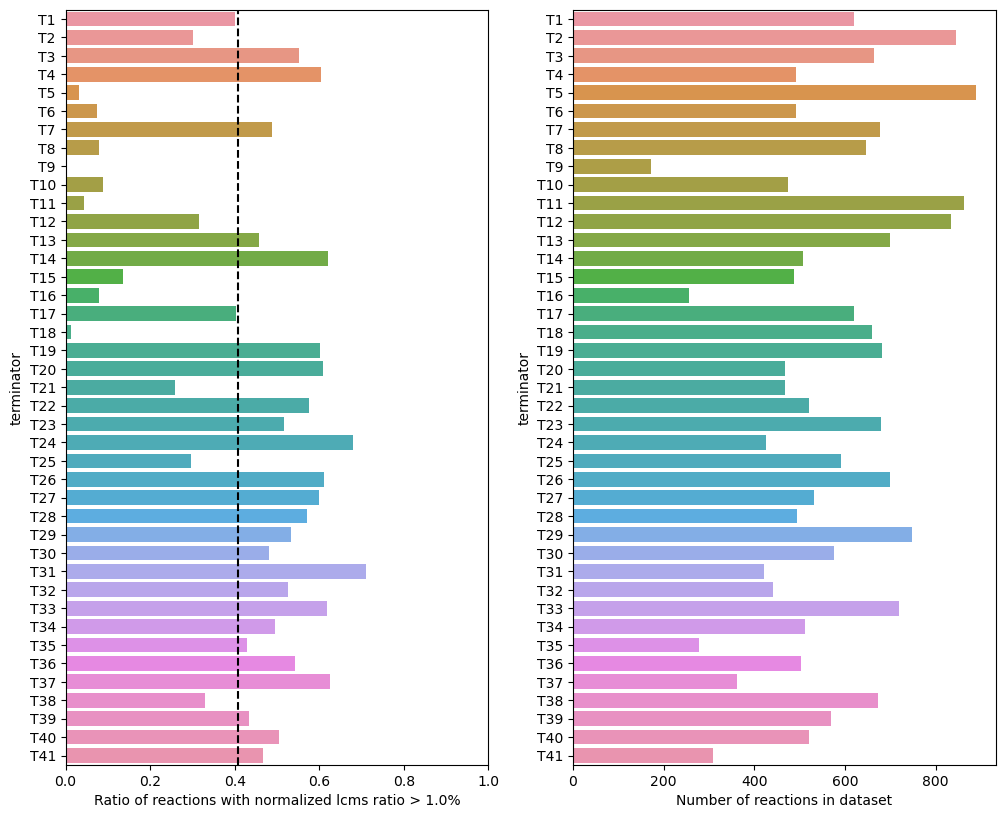

In [45]:
# show how many reactions are successful for each terminator
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,10))

axs[0].axvline(success_rates_by_terminator['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_terminator['success_rate'], y=success_rates_by_terminator['terminator'], ax=axs[0])
sns.barplot(x=success_rates_by_terminator['n_all'], y=success_rates_by_terminator['terminator'], ax=axs[1])

axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.1%}')
axs[0].set_xlim(0,1)
axs[1].set_xlabel('Number of reactions in dataset')

plt.show()

### Trends within builing block classes <a id=5></a>
Let's look at how well different types of initiators, monomers, terminators react

In [46]:
# let's check Initiators
success_rates_by_initiator_type = calc_success_rate(df, 'initiator_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_initiator_type.iterrows():
    print(f'Success rate for {i[0]}: {i[3]:.1%} ({i[1]}/{i[2]})')

Success rate for KAT_arom: 38.6% (4080/10565)
Success rate for KAT_al: 44.1% (1624/3681)
Success rate for KAT_hetarom: 40.6% (3593/8845)


In [47]:
# let's check Monomers
success_rates_by_monomer_type = calc_success_rate(df, 'monomer_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_monomer_type.iterrows():
    print(f'Success rate for {i[0]}: {i[1]/i[2]:.1%} ({i[1]}/{i[2]})')

Success rate for Mon_sub_3: 51.7% (7832/15161)
Success rate for Mon_fused: 23.3% (528/2269)
Success rate for Mon_spiro_2: 23.0% (401/1742)
Success rate for Mon_spiro_3: 16.1% (354/2200)
Success rate for Mon_sub_2: 10.6% (182/1719)


In [48]:
# let's check Terminators
success_rates_by_terminator_type = calc_success_rate(df, 'terminator_type', THRESHOLD, sort_results=False)
for _, i in success_rates_by_terminator_type.iterrows():
    print(f'Success rate for {i[0]}: {i[1]/i[2]:.1%} ({i[1]}/{i[2]})')

Success rate for TerTH: 52.2% (6362/12192)
Success rate for TerABT: 26.9% (2935/10899)


### Trends controlled for monomer behavior <a id=6></a>
Here we want to look at initiator and terminator success rates only for those monomers that typically work.
For simplicity, we accept only monomers that are have a success ratio of >= 10%

In [49]:
successful_monomers = success_rates_by_monomer.loc[success_rates_by_monomer['success_rate'] >= 0.10, 'monomer']
successful_monomers

0      M1
1      M2
3      M4
4      M5
5      M6
6      M7
7      M8
8      M9
9     M10
10    M11
12    M13
13    M16
14    M17
15    M18
16    M19
17    M20
18    M21
19    M23
20    M24
22    M28
23    M29
24    M30
25    M31
26    M32
27    M33
28    M34
29    M35
31    M37
32    M38
34    M40
35    M41
36    M42
37    M43
38    M44
39    M45
40    M46
41    M47
42    M48
44    M51
45    M52
47    M54
48    M56
49    M59
50    M60
51    M62
53    M65
54    M66
55    M67
56    M69
59    M74
Name: monomer, dtype: object

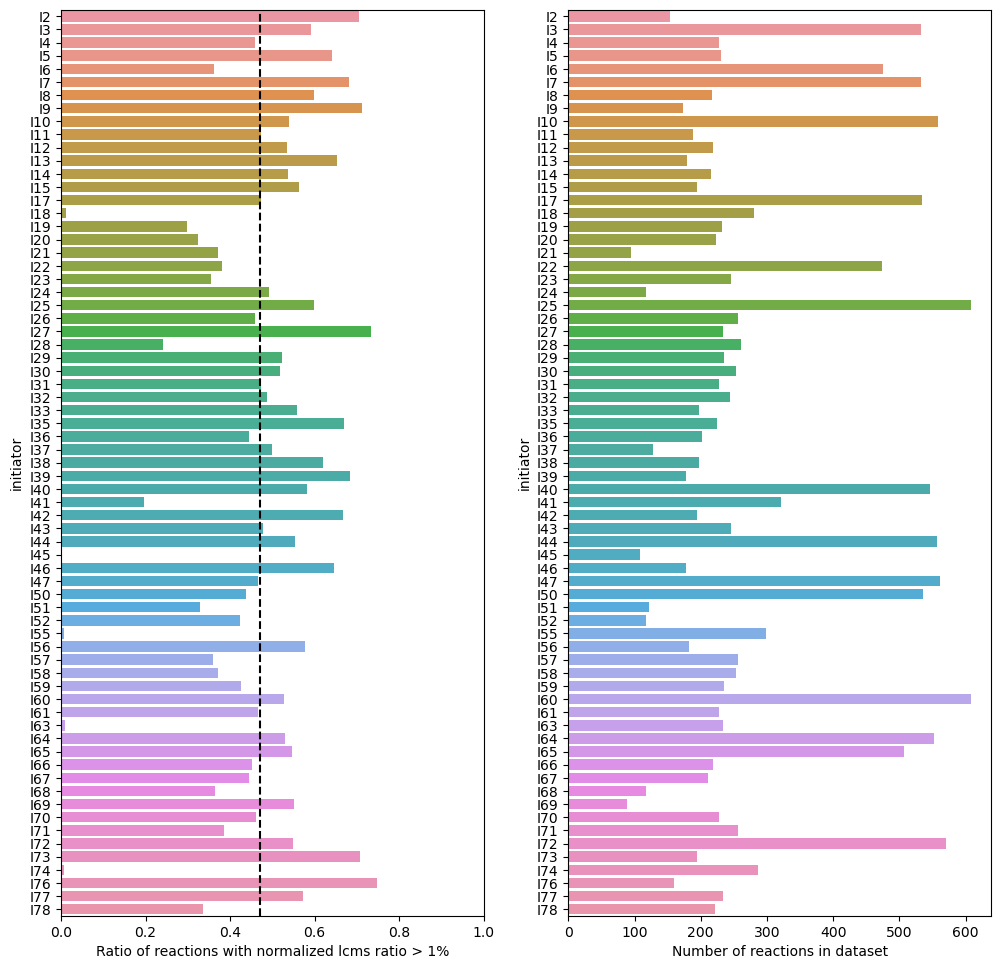

In [50]:
success_rates_by_initiator_for_successful_monomers = calc_success_rate(df.loc[df['monomer'].isin(successful_monomers)], 'initiator', THRESHOLD)

# show how many reactions are successful for each initiator, only considering monomers that react well
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
axs[0].axvline(success_rates_by_initiator_for_successful_monomers['success_rate'].mean(), ls='--', c='black')
sns.barplot(x=success_rates_by_initiator_for_successful_monomers['success_rate'], y=success_rates_by_initiator_for_successful_monomers['initiator'], ax=axs[0])
axs[0].set_xlabel(f'Ratio of reactions with normalized lcms ratio > {THRESHOLD:.0%}')
axs[0].set_xlim(0,1)

sns.barplot(x=success_rates_by_initiator_for_successful_monomers['n_all'], y=success_rates_by_initiator_for_successful_monomers['initiator'], ax=axs[1])
axs[1].set_xlabel('Number of reactions in dataset')
plt.show()

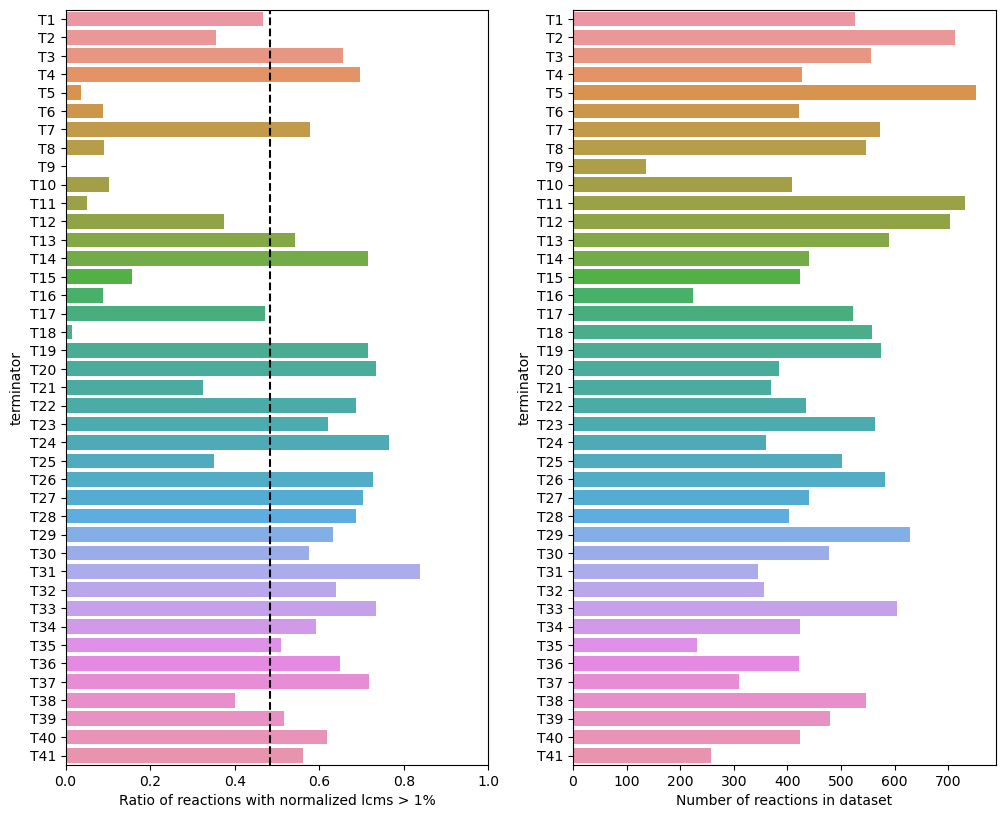

In [51]:
success_rates_by_terminator_for_successful_monomers = calc_success_rate(df.loc[df['monomer'].isin(successful_monomers)], 
                                                                        'terminator', 
                                                                        THRESHOLD,
                                                                       )

# show how many reactions are successful for each terminator, only considering monomers that react well
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
sns.barplot(x=success_rates_by_terminator_for_successful_monomers['success_rate'], y=success_rates_by_terminator_for_successful_monomers['terminator'], ax=axs[0])
axs[0].axvline(success_rates_by_terminator_for_successful_monomers['success_rate'].mean(), ls='--', c='black')
axs[0].set_xlabel(f'Ratio of reactions with normalized lcms > {THRESHOLD:.0%}')
axs[0].set_xlim(0,1)

sns.barplot(x=success_rates_by_terminator_for_successful_monomers['n_all'], y=success_rates_by_terminator_for_successful_monomers['terminator'], ax=axs[1])
axs[1].set_xlabel('Number of reactions in dataset')
plt.show()

What remains to do?

- Investigate what happens to the monomers where no product A is formed: Do they stall at F/G? Do they not react and we get a lot of D or H instead?

In [52]:
db.show_image('I63')